# End-to-end Multi-Class Dog Breed Classification

An image classifier using TensorFlow and TensorFlow Hub.

## 1. Problem

Pretty straigt forward. If I have a picture of a dog, I want to know what breed of dog it is.

## 2. Data

The data is from Kaggle's dog breed identification [competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

## 3. Evaluation

[Evaluation metrics](https://www.kaggle.com/competitions/dog-breed-identification/overview/evaluation): evaluated on Multi-class Log Loss

## 4. Features

* I'm dealing with images (unstructured data)
  - good candidate for deep learning/transfer learning
* 10,000+ images in training set
  - labels
* 10,000+ images in test set
  - no labels

## Prepare Workspace

- import tf and tf hub
- set up GPU
- see colab shortcuts `ctrl+m+h`

In [1]:
import pandas as pd
import numpy as np
# tensorflow import
import tensorflow as tf
import tensorflow_hub as hub
print("tf version: ", tf.__version__)
print("tf hub version: ", hub.__version__)

repo_path = "/content/drive/MyDrive/tf_breed_classification"

# check for gpu availability
print("GPU", "Available :)" if tf.config.list_physical_devices("GPU") else "Not Available :(")

tf version:  2.14.0
tf hub version:  0.15.0
GPU Available :)


In [2]:
# unzip data into googleDrive
# %cd /content/drive/MyDrive/tf_breed_classification/data/dog-vision-real

# !unzip "/content/drive/MyDrive/tf_breed_classification/data/dog-breed-identification.zip" -d "/content/drive/MyDrive/tf_breed_classification/data/dog-vision-real"


## Get our data(images) into Tensors(numerical)

Start by checking out the labels

In [3]:
labels_df = pd.read_csv(f"{repo_path}/data/dog-vision/labels.csv")
print(labels_df.describe())
labels_df.head()

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


<Axes: >

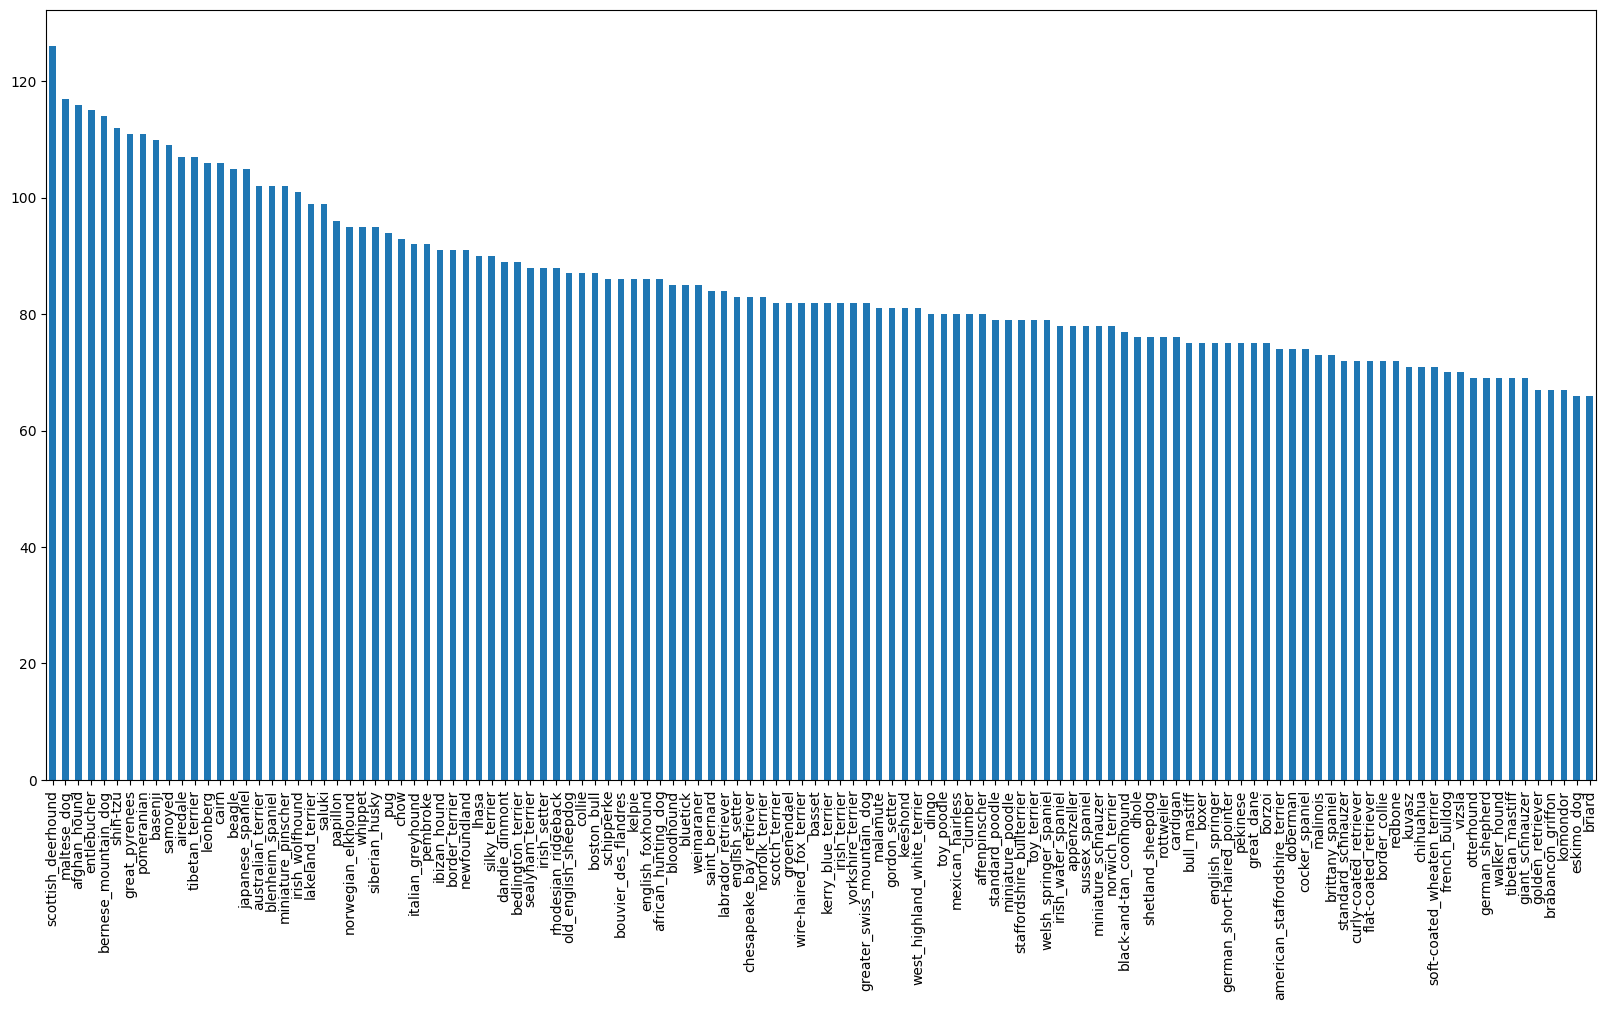

In [4]:
# how many images per breed
labels_df["breed"].value_counts().plot.bar(figsize=(20, 10))

- minimum: at **least** 10 items per class
- reccomended: 100+
- what we have: median = 82

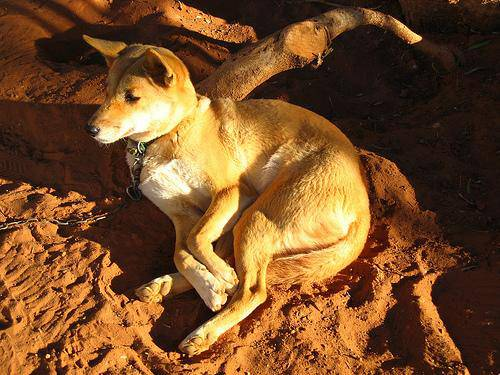

In [5]:
# view image
from IPython.display import Image
Image(f"{repo_path}/data/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

In [6]:
# create pathnames from imageIds
file_paths = [f"{repo_path}/data/dog-vision/train/{fname}.jpg" for fname in labels_df["id"]]
len(file_paths), file_paths[:5]

(10222,
 ['/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/001cdf01b096e06d78e9e5112d419397.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/0021f9ceb3235effd7fcde7f7538ed62.jpg'])

In [7]:
import os
if (len(os.listdir(f"{repo_path}/data/dog-vision/train/")) == len(file_paths)):
  print("file_paths len matches number of files")
else:
  print("Error: files dont match. Check target directory")

file_paths len matches number of files


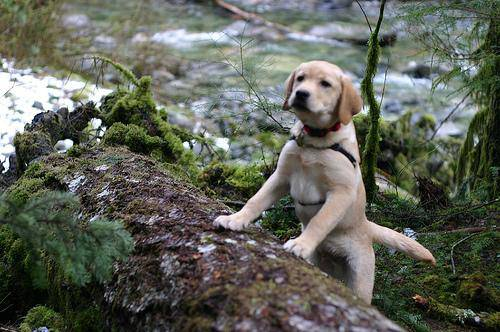

In [8]:
# test that file_names is pointing to usable paths
Image(file_paths[888])

Image file_paths are prepared. Moving on to labels
> always check for consist data shape

In [9]:
labels = np.array(labels_df["breed"])

In [10]:
# check for same number between labels and filenames
if len(labels) == len(file_paths):
  print("Number of labels matches number of file paths")
else:
  print("Error: Number of labels does NOT match number of file paths")


Number of labels matches number of file paths


In [11]:
unique_breeds = np.unique(labels)
len(unique_breeds)


120

In [12]:
# turn a single label into an array of booleans
# apply to every label
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [13]:
# turn every label into a bool array

boolean_labels = [label == unique_breeds for label in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

#### bool array into integers for model explanation

In [14]:
# Example
print(labels[0]) # original label
print(np.where(unique_breeds == labels[0])) # index where lavel occurs
print(boolean_labels[0].argmax()) # index where label occurs in boolean array
print(boolean_labels[0].astype(int)) # should be a 1 where the sample label occurs


boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set
- Kaggle competition doesn't include a validation set. So I'll will make my own.
- important to have the 3 sets
  - training, validation, test

In [15]:
# Setup X & y vars
X = file_paths
y = boolean_labels

Experiment with ~1000 images before fully training the model

In [16]:
# Set experiment num
# colab params, cool!
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step: "1000"}

In [17]:
# split data
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)

In [18]:
# check out training data
X_train[:5], y_train[:2]

(['/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/00bee065dcec471f26394855c5c2f3de.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  '/content/drive/MyDrive/tf_breed_classification/data/dog-vision/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         Fal

## Preprocessing Images

#### Turning images into Tensors
helper func:

1. Take image filepath as input
2. Use ts to read file and save in `image` var
3. Make `image` into tensors
4. Normalize `image`. Convert the color values from 0-255 to 0-1 values
5. Resize `image` to be (224, 224) shape
6. Return modified image

In [19]:
# image preprocess func
from matplotlib.pyplot import imread

IMG_SIZE = 224

def process_image(image_path):
  """
  Takes an image file path and turns it into a tensor
  """
  # read image (2 options shown)
  # image = imread(image_path)
  image = tf.io.read_file(image_path)

  # turn image into tensor with rgb color channels
  image = tf.image.decode_jpeg(image, channels=3)

  # Normalization
  image = tf.image.convert_image_dtype(image, tf.float32)

  # resize image (224, 224)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])

  return image


## Turning data into Batches

All the data might not fit into memory so it needs to be batched
>32 at a time is considered the standard

Tensor tuple structure:
- `(image, label)`

In [20]:
# tensor tuple func

def get_image_label(image_path, label):
  """
  process image and return tensor tuple
  """

  image = process_image(image_path)
  return image, label


In [21]:
# define batch size
BATCH_SIZE = 32

# batching func
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles training data but not validation data.
  Accepts test data with no labels.
  """

  # handle test data
  if test_data:
    print("Creating test batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # no labels
    data_batch = data.map(process_image).batch(batch_size)
    return data_batch

  # handle validation data. doesnt need to be shuffled
  elif valid_data:
    print("Creating validation batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # file paths
                                               tf.constant(y))) # labels

    data_batch = data.map(get_image_label).batch(batch_size)
    return data_batch

  # handle training batch
  else:
    print("Creating training batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))

    # shuffling path_names and labels before mapping image processor here
    # is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # create (img, label) and turns path into a preprocessed image
    data = data.map(get_image_label)

    # batch data
    data_batch = data.batch(batch_size)
    return data_batch


In [22]:
# test above function
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

train_data.element_spec, val_data.element_spec

Creating training batches...
Creating validation batches...


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

## Visualizing Data Batches

In [23]:
import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_images(images,labels, amount_to_show=25):
  """
  Displays a plot of images/labels from a batch
  """
  plt.figure(figsize=(10, 10))
  # loop through images
  for i in range(amount_to_show):
    # create subplotes (5 x 5)
    ax = plt.subplot(5, 5, i+1)
    # display image
    plt.imshow(images[i])
    # add image lable as title
    plt.title(unique_breeds[labels[i].argmax()])
    # turn off gridlines
    plt.axis("off")

In [24]:
# data is currently batched so it needs to be converted into an iterator
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels)

(32, 32)

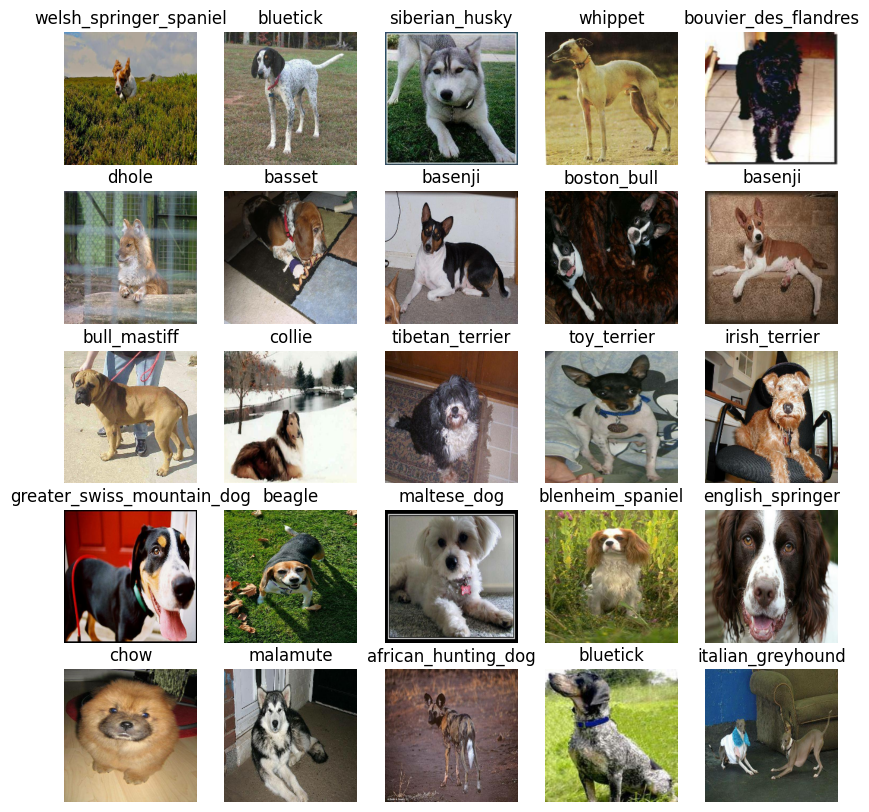

In [25]:
show_images(train_images, train_labels)

## Building a Model

There are many ways to build a model. Need to define a few things first:
* Input shape to our model
* Output shape
* The URL of the model
  - [Model URL in tf_hub](https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5)

In [26]:
# setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# output shape of model
OUTPUT_SHAPE = len(unique_breeds)

# model URL from tf Hub
# note: checkout v4 vs v5
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Keras deep learning model

make a function which:
* takes input shape, output shape and the model we've chosen as parameters.
* Defines the layers in a Keras model in sequential fashion.
* Compiles the model (evaluate and improve)
* Builds the model
* returns the model

All steps can be found [here](https://www.tensorflow.org/guide/keras)

In [30]:
# function that builds Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with: ", model_url)

  # setup model layers
  model = tf.keras.Sequential([hub.KerasLayer(model_url), # layer 1 (input)
                               tf.keras.layers.Dense(units=output_shape, activation="softmax") # layer 2 (output)
                               ])

  # compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # build the model
  model.build(input_shape)

  return model


In [31]:
model = create_model()
model.summary()

Building model with:  https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5552953 (21.18 MB)
Trainable params: 120240 (469.69 KB)
Non-trainable params: 5432713 (20.72 MB)
_________________________________________________________________
